In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.datasets.mnist import load_data

In [3]:
(x_train, y_train), (x_test, y_test) = load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

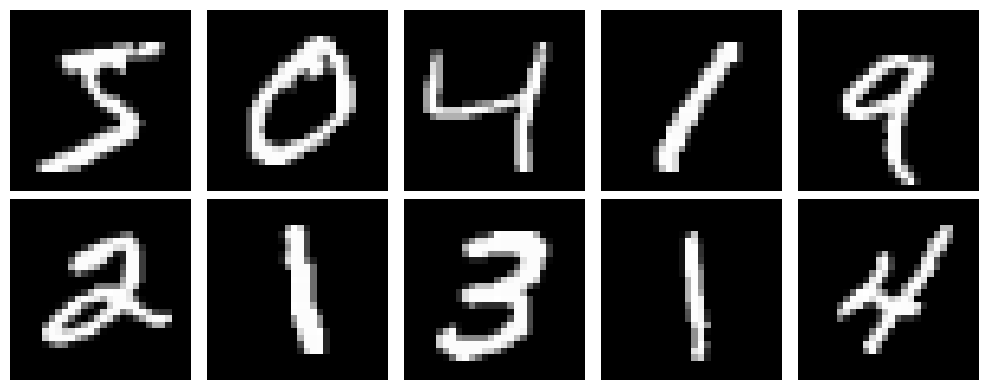

In [4]:
def plot_samples(data):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i], cmap = "gray")
        ax.axis("off")
    fig.tight_layout()

plot_samples(x_train)

In [5]:
# plot_samples(x_train[50000])
x_train[50000].shape

(28, 28)

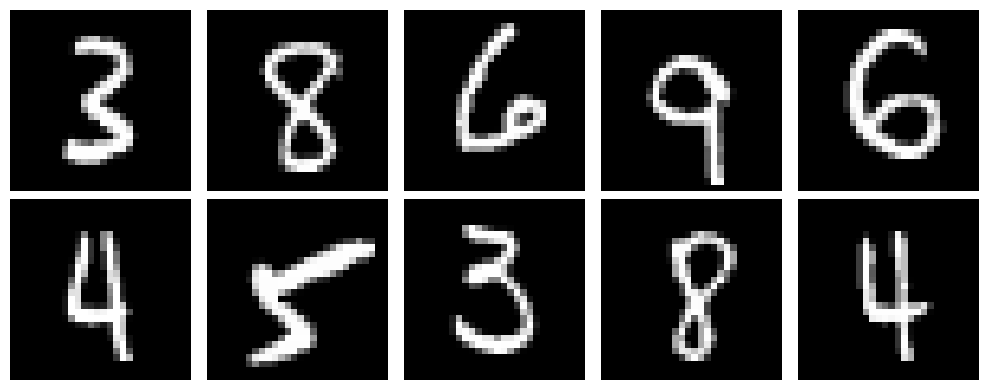

In [6]:
plot_samples(x_train[50000:50010])

In [7]:
X_train = x_train.astype("float32")/255
X_test = x_test.astype("float32")/255
X_train.min(), X_train.max()

(0.0, 1.0)

## Train|Val|Test split

In [8]:
from sklearn.model_selection import train_test_split

# we already have xtrain: 60000 samples
# xtrain val: 50000 samples -> training apart for validation and hyperparameter tuning
# xval: 10000 samples -> validation used for hyperparameter tuning and validation loss curves
# train on trainval and validate on val to hyperparameter tune then when finished train on whole training dataset
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=1/6, random_state=42)

In [9]:
X_train_val.shape, X_val.shape

((50000, 28, 28), (10000, 28, 28))

In [10]:
# we will use image data generator to augment our data
# it requires rank 4 - number of "features" those above are rank 3
X_train_val[..., None].shape

(50000, 28, 28, 1)

In [11]:
X_train_val= X_train_val[..., None]
X_train= X_train[..., None]
X_val= X_val[..., None]
X_test= X_test[..., None]

## Data augmentation

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator= ImageDataGenerator(rotation_range= 90)

# batch size 32 - used for mini-batch gradiant descent which gives stochasticity in backpropagation
# flow is used for regenerating images after it has been exhausted
# this is because we will train in many epochs
train_generator= train_image_generator.flow(X_train, y_train, batch_size= 32)

train_generator

In [13]:
# this is the first batch
train_generator[0][0].shape

(32, 28, 28, 1)

In [14]:
# second batch
train_generator[1][0].shape

(32, 28, 28, 1)

In [15]:
# labels for second batch
train_generator[1][1].shape

(32,)

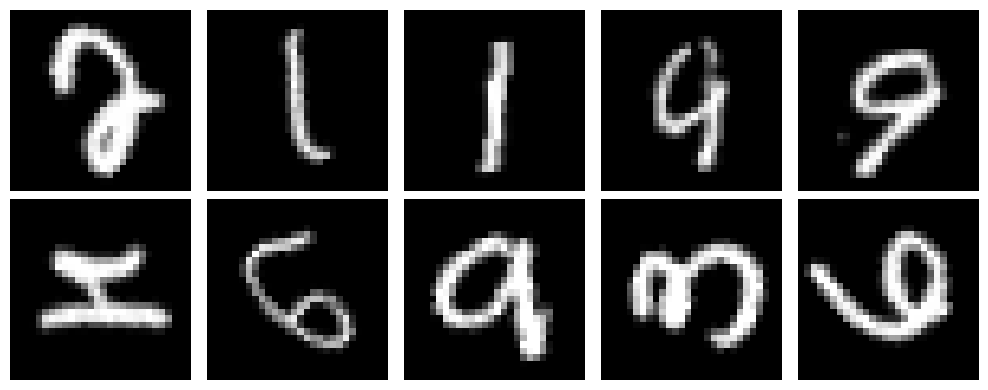

In [16]:
plot_samples(next(train_generator)[0])

## Make a good augmentation

In [22]:
train_image_generator = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=False,
    height_shift_range=0.2,
    width_shift_range=0.2,
)

test_image_generator = ImageDataGenerator()

train_generator = train_image_generator.flow(X_train, y_train, batch_size=32)
train_val_generator = train_image_generator.flow(X_train_val, y_train_val, batch_size=32)
val_generator = test_image_generator.flow(X_val, y_val, batch_size=32)

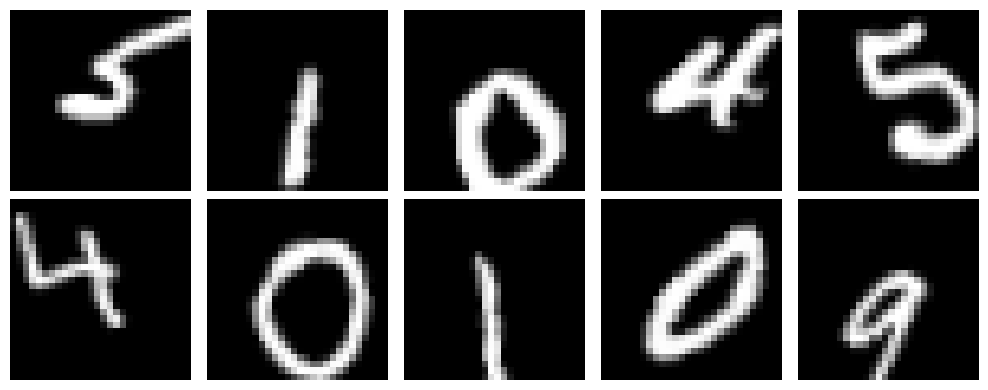

In [18]:
plot_samples(next(train_generator)[0])

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def CNN_model(learning_rate=0.001, drop_rate=0.5, kernels=[32, 32]):
    adam = Adam(learning_rate=learning_rate)

    model = Sequential(name="CNN_model")

    for number_kernel in kernels:
        conv_layer = Conv2D(
            number_kernel,
            kernel_size=(3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=X_train.shape[1:],
        )

        model.add(conv_layer)
        # defaults to pool_size if None
        model.add(MaxPooling2D(pool_size=(2, 2), strides = 2))

    #MLP part
    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation="relu", kernel_initializer="he_normal"))
    model.add(Dense(10, activation="softmax"))

    model.compile(
        loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["acc"]
    )

    return model

model = CNN_model(drop_rate=.5)

model.summary()

c:\Users\milto\Documents\skola\Artificial_Intelligence2-Milton-OPA23\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "CNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       205,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,194 (848.41 KB)

 Trainable params: 217,194 (848.41 KB)

 Non-trainable params: 0 (0.00 B)

## Train on augmented data

In [20]:
# number of steps for minibach per epoch
steps_per_epochs= len(X_train_val)//32
validation_steps= len(X_val)//32
steps_per_epochs, validation_steps

# number of batches to be ran in one epoch

(1562, 312)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(
    monitor="val_acc", mode="max", patience=5, restore_best_weights=True
)
model.fit(
    train_val_generator,
    steps_per_epoch=steps_per_epochs,
    epochs=50,
    callbacks=early_stopper,
    validation_data= val_generator, # whis will give us batches for validation
    validation_steps= validation_steps,
)

Epoch 1/50
   8/1562 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - acc: 0.0854 - loss: 3.2052 

c:\Users\milto\Documents\skola\Artificial_Intelligence2-Milton-OPA23\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - acc: 0.6429 - loss: 1.0800 - val_acc: 0.9623 - val_loss: 0.1274
Epoch 2/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 24us/step - acc: 0.8750 - loss: 0.1838 - val_acc: 0.9375 - val_loss: 0.0970
Epoch 3/50
   8/1562 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - acc: 0.9184 - loss: 0.3074  

C:\Users\milto\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - acc: 0.9030 - loss: 0.3066 - val_acc: 0.9745 - val_loss: 0.0828
Epoch 4/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 11us/step - acc: 0.9375 - loss: 0.0699 - val_acc: 1.0000 - val_loss: 0.0027
Epoch 5/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - acc: 0.9236 - loss: 0.2386 - val_acc: 0.9748 - val_loss: 0.0843
Epoch 6/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 9us/step - acc: 0.9375 - loss: 0.1400 - val_acc: 1.0000 - val_loss: 0.0034
Epoch 7/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - acc: 0.9375 - loss: 0.1974 - val_acc: 0.9805 - val_loss: 0.0604
Epoch 8/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 9us/step - acc: 0.9062 - loss: 0.1185 - val_acc: 1.0000 - val_loss: 0.0070
Epoch 9/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - acc: 0.9456 - loss: 0.1754 - val_acc: 0.9812 - val_loss: 0.0609


In [ ]:
metrics= pd.DataFrame(model.history.history)
metrics

,acc,loss,val_acc,val_loss
0,0.783942,0.656887,0.964343,0.120278
1,0.937500,0.211729,1.000000,0.076291
2,0.916286,0.263548,0.976162,0.075733
3,0.937500,0.173051,1.000000,0.004960
4,0.935219,0.206064,0.980669,0.064941
5,0.812500,0.608433,1.000000,0.070550
6,0.944484,0.175861,0.982873,0.057988


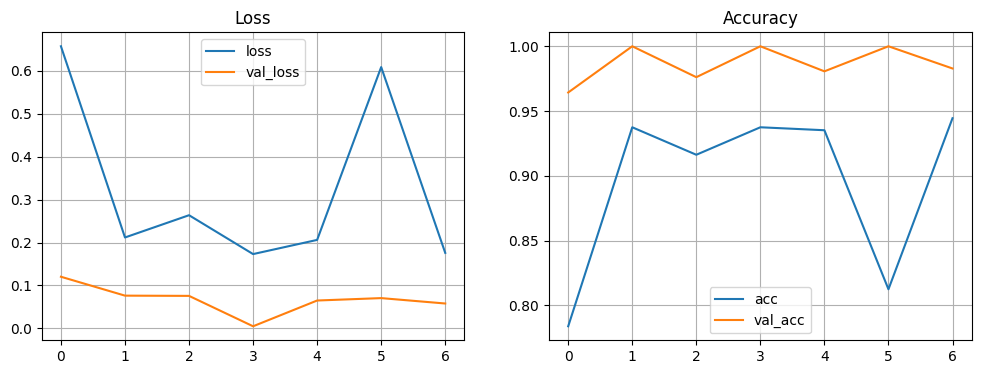

In [ ]:
def plot_metrics(metrics):
    _, ax = plt.subplots(1,2, figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], title = "Loss", grid = True)
    metrics[["acc", "val_acc"]].plot(ax = ax[1], title = "Accuracy", grid = True)

plot_metrics(metrics)

In [ ]:
model= CNN_model()
model.fit(train_generator, steps_per_epoch= steps_per_epochs, epochs= 10)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  16/1562 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - acc: 0.1077 - loss: 2.7079

W0000 00:00:1714997136.204118     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - acc: 0.6567 - loss: 1.0354
Epoch 2/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - acc: 0.9010 - loss: 0.3098  
Epoch 3/10
   5/1562 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - acc: 0.9065 - loss: 0.2675  

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - acc: 0.9149 - loss: 0.2661
Epoch 4/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.9327 - loss: 0.2124  
Epoch 5/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - acc: 0.9389 - loss: 0.1927
Epoch 6/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.9438 - loss: 0.1799  
Epoch 7/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - acc: 0.9441 - loss: 0.1761
Epoch 8/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.9506 - loss: 0.1563  
Epoch 9/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - acc: 0.9526 - loss: 0.1522
Epoch 10/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.9540 - loss: 0.1397  


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred= model.predict(X_test)
y_pred

111/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1714997251.001179     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


W0000 00:00:1714997251.682231     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([[4.2722418e-06, 3.0032641e-08, 4.6631749e-04, ..., 9.9807632e-01,
        1.3181210e-07, 1.4248006e-03],
       [6.8368361e-05, 4.8375105e-06, 9.9990809e-01, ..., 6.6359240e-07,
        7.5314580e-07, 3.0718248e-08],
       [3.0677507e-05, 9.9992204e-01, 1.8296184e-07, ..., 2.6329852e-05,
        8.3482956e-07, 5.3904660e-07],
       ...,
       [1.1823734e-09, 1.1674821e-09, 7.8183510e-10, ..., 9.5941148e-09,
        1.3683150e-07, 1.5780098e-06],
       [2.2360109e-06, 1.3554056e-09, 2.3223387e-07, ..., 1.9686318e-08,
        1.9100134e-04, 6.5928430e-06],
       [4.7446258e-05, 1.5677562e-10, 5.9578369e-06, ..., 6.7745989e-11,
        1.9748499e-05, 1.1041573e-06]], dtype=float32)

In [ ]:
y_pred[0], y_test[7]

(array([4.2722418e-06, 3.0032641e-08, 4.6631749e-04, 1.0301209e-06,
        2.7083643e-05, 3.0556073e-08, 4.0418360e-11, 9.9807632e-01,
        1.3181210e-07, 1.4248006e-03], dtype=float32),
 9)

In [ ]:
y_pred[50], y_test[50]

(array([1.8834381e-06, 3.9299524e-09, 2.2765663e-08, 6.8652098e-11,
        5.1044949e-06, 3.8571266e-06, 9.9998713e-01, 3.5359771e-11,
        7.4837004e-07, 1.2919829e-06], dtype=float32),
 6)

In [ ]:
import numpy as np
y_pred= np.argmax(y_pred, axis= 1)
y_pred

array([7, 2, 1, ..., 4, 5, 6])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.98      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.96      0.98      1028
           8       0.98      0.99      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



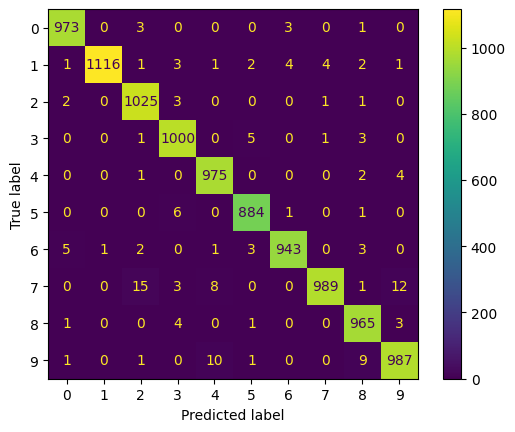

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()